In [49]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from stingray.powerspectrum import AveragedPowerspectrum, DynamicalPowerspectrum
from stingray.crossspectrum import AveragedCrossspectrum
from stingray.events import EventList
from stingray.lightcurve import Lightcurve
from stingray.gti import create_gti_from_condition

#from astropy.visualization import astropy_mpl_style
#plt.style.use(astropy_mpl_style)
from astropy.io import fits
from astropy.table import Table
from astropy.utils.data import get_pkg_data_filename
from scipy.optimize import curve_fit
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import stingray

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
obsid=90701332002
evtA="/Volumes/5T_disk1/Data/GRS1915p105/NuSTAR/work_new/%s_out/nu%sA01_cl.evt"%(obsid,obsid)
evtB="/Volumes/5T_disk1/Data/GRS1915p105/NuSTAR/work_new/%s_out/nu%sB01_cl.evt"%(obsid,obsid)

In [51]:
evA = EventList.read(evtA, 'hea')
#evB = EventList.read(evtB, 'hea')

/Users/kldsky/anaconda3/lib/python3.9/site-packages/stingray/io.py:235: UserWarning: Column energy not found
  warnings.warn('Column ' + a + ' not found')


In [52]:
all_ev = evA.join(evB)

In [53]:
NBINS = (100,100)
hdu_list = fits.open(evtA, memmap=True)
evt_data = Table(hdu_list[1].data)
#print(hdu_list[1].columns)

In [54]:
ii = np.in1d(evt_data['DET_ID'], [0,1,2,3])
np.sum(ii)

404309

Text(0, 0.5, 'y')

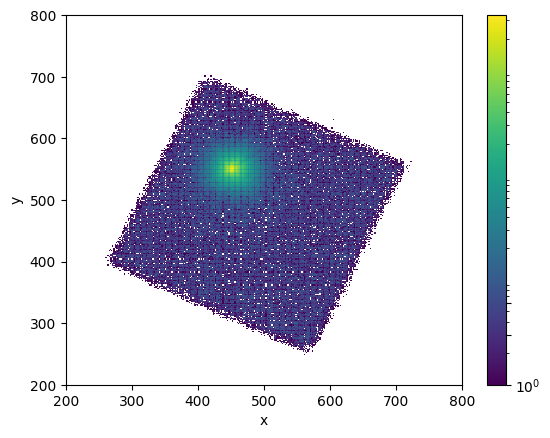

In [55]:
from matplotlib.colors import LogNorm
NBINS = (400,400)
img_zero_mpl = plt.hist2d(evt_data['X'][ii], evt_data['Y'][ii], NBINS, 
                          cmap='viridis', norm=LogNorm())

cbar = plt.colorbar(ticks=[1.0,3.0,6.0])
#cbar.ax.set_yticklabels(['1','3','6'])
plt.xlim(200,800)
plt.ylim(200,800)
plt.xlabel('x')
plt.ylabel('y')

In [56]:
lc = all_ev.to_lc(5)
new_gti = create_gti_from_condition(lc.time, lc.countrate > 5, safe_interval=1)
lc.gti = new_gti
lc.apply_gtis()

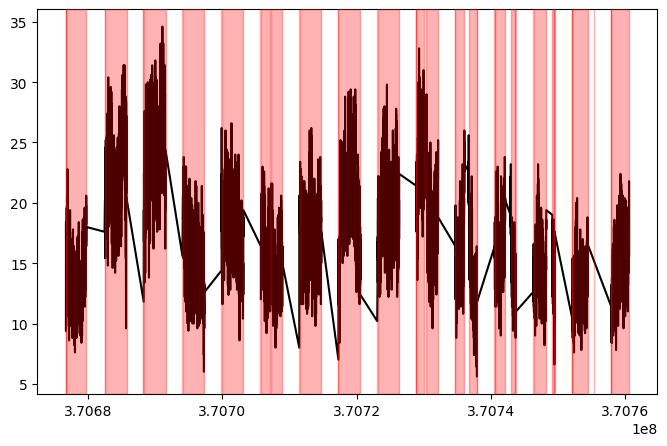

In [57]:
plt.figure(figsize=(8, 5))
plt.plot(lc.time, lc.countrate,'-k')
#bad_time_intervals = list(zip(lc.gti[:-1, 1], lc.gti[1:, 0]))
time_intervals = list(lc.gti)
for b in time_intervals:
    plt.axvspan(b[0], b[1], color='r', alpha=0.3, zorder=10)
#plt.ylim([5000, 6500])

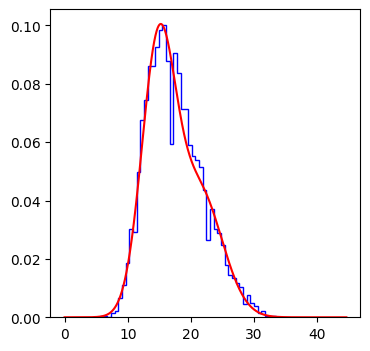

In [58]:
plt.figure(figsize=(4, 4))
# Generate some sample data
data = lc.countrate
X=data.reshape(-1, 1)
N=2
kmeans = KMeans(n_clusters=N, random_state=0).fit(X)
# 高斯混合模型拟合
gmm = GaussianMixture(n_components=N)
gmm.fit(X)
# 绘制拟合结果
x = np.linspace(0, max(lc.countrate)+10, 10000).reshape(-1, 1)
y = np.exp(gmm.score_samples(x))
#plt.hist(lc.countrate[mk],bins=50,histtype='step',color='r')
plt.hist(X, bins=50, density=True, histtype='step',color='b')
plt.plot(x, y, '-r')

In [59]:
weights = gmm.weights_
means = gmm.means_
covariances = gmm.covariances_
#print("weights:", weights)
means=np.sort(means.reshape(1,N))[0]
print("means:", means)
#print("covariances:", covariances)

means: [14.83507413 21.29390718]


In [60]:
#deadtime correction
from stingray.deadtime.fad import calculate_FAD_correction, FAD
dt=0.001
segment_size = 50.
results = \
    FAD(evA, evB, segment_size, dt, norm="leahy", plot=False,
                      smoothing_alg='gauss',
                      smoothing_length=segment_size*2,
                      strict=True, verbose=False,
                      tolerance=0.05,return_objects=True)
ptot_f=results['ptot'].rebin_log(0.03)
pds = AveragedPowerspectrum.from_events(all_ev, segment_size=50, dt=0.001, norm='leahy')
pds=pds.rebin_log(0.03)

855it [00:10, 80.96it/s]
855it [00:00, 1405.37it/s]


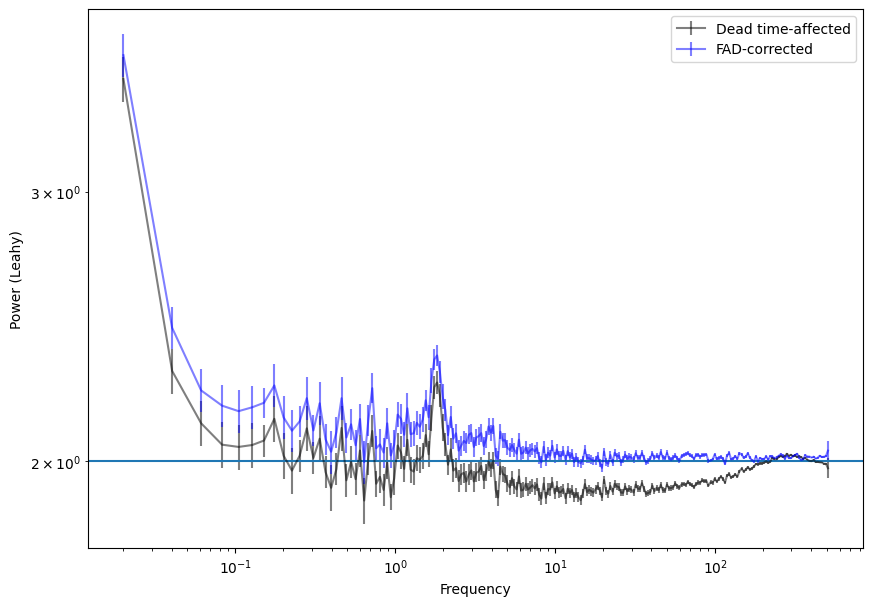

In [67]:
plt.figure(figsize=(10,7))
plt.errorbar(pds.freq, pds.power,yerr=pds.power_err, label='Dead time-affected',alpha=0.5, fmt='-k')
plt.errorbar(ptot_f.freq, ptot_f.power, yerr=pds.power_err, label='FAD-corrected', alpha=0.5, fmt='-b')
plt.axhline(y=2)
plt.xlabel("Frequency")
plt.ylabel("Power (Leahy)")
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [62]:
lc = all_ev.to_lc(0.01)
#lc.time=lc.time-lc.time[0]
dps = stingray.DynamicalPowerspectrum(lc, segment_size=100, norm='leahy')

421it [00:00, 7425.33it/s]
421it [00:00, 1502.57it/s]


In [63]:
dps.rebin_frequency(df_new=3, method="average")
#dps.rebin_time(dt_new=100.0, method="average")

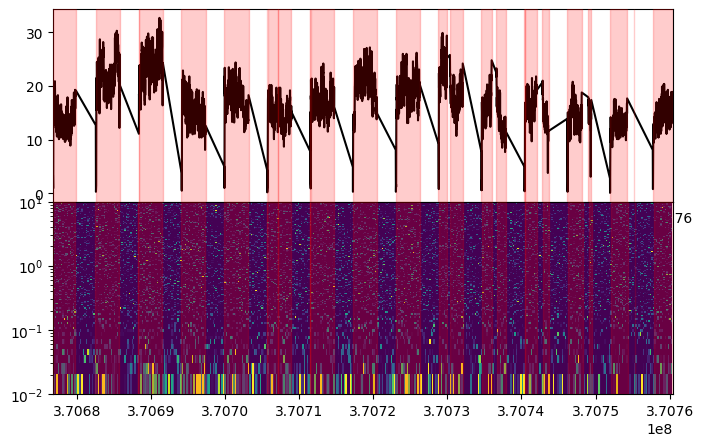

In [65]:
lc1 = all_ev.to_lc(10)
new_gti = create_gti_from_condition(lc1.time, lc1.countrate > 0, safe_interval=1)
lc1.gti = new_gti
lc1.apply_gtis()
fig, axs = plt.subplots(2,1,figsize=(8, 5))
extent = min(dps.time), max(dps.time), min(dps.freq), max(dps.freq)
axs[0].plot(lc1.time, lc1.countrate,'-k')
#tracing = dps.trace_maximum(min_freq=6, max_freq=10)
#axs[1].plot(dps.time, dps.freq[tracing], color='orange', alpha=0.5)
axs[1].imshow(dps.dyn_ps, origin="lower", aspect="auto", 
              vmin=3.0, vmax=15.0, 
              interpolation="none", extent=extent)
bad_time_intervals = list(new_gti)
for b in bad_time_intervals:
    axs[0].axvspan(b[0], b[1], color='r', alpha=0.2, zorder=10)
    axs[1].axvspan(b[0], b[1], color='r', alpha=0.2, zorder=10)
#plt.colorbar()
axs[0].set_xlim(list(new_gti)[0][0],list(new_gti)[-1][-1])
axs[1].set_ylim(0.01, 10)
#plt.xscale('log')
plt.yscale('log')
plt.subplots_adjust(hspace=0,wspace=0)

### 